In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Load
model_mask = torch.load(
    "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/training_data_cache/mESC_no_scale_linear/chr1/motif_mask_chr1.pt",
    map_location="cpu",
)

# ensure numpy
mask = model_mask.detach().cpu().numpy() if isinstance(model_mask, torch.Tensor) else np.array(model_mask)


## Sliding Window Motif Masking

Visualize the raw sliding window scores. Calculated as the total $-log10(\text{p-value})$ prediction that a TF will bind to a peak compared to background sequences.

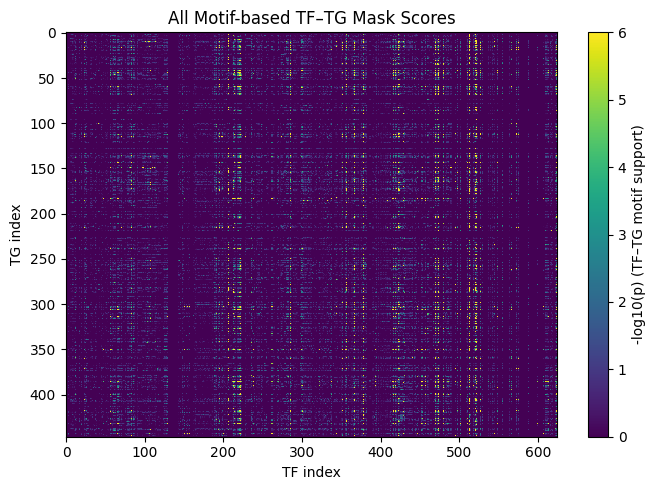

In [4]:
plt.figure(figsize=(7, 5))
import matplotlib.colors as mcolors

cap = 6.0
vis = np.clip(mask, 0, cap)

im = plt.imshow(vis, aspect="auto", interpolation="nearest", vmin=0, vmax=cap)
plt.colorbar(im, label="-log10(p) (TF–TG motif support)")
plt.xlabel("TF index")
plt.ylabel("TG index")
plt.title(f"All Motif-based TF–TG Mask Scores")
plt.tight_layout()
plt.show()

We binarize edges to only include those with a p-value threshold below $-log10(\text{threshold})$

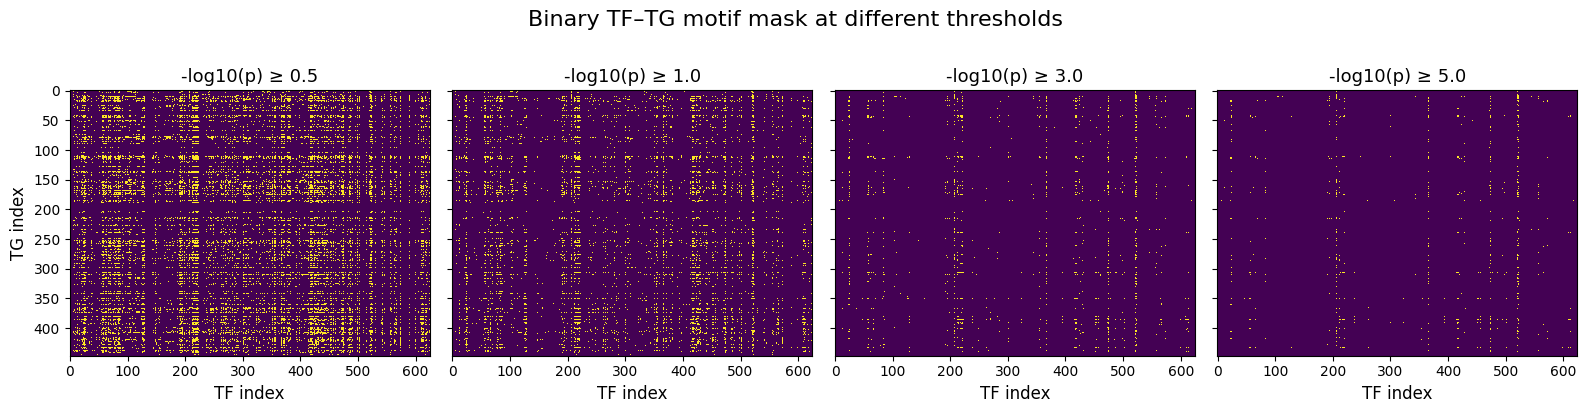

In [5]:
thresholds = [0.5, 1.0, 3.0, 5.0]

fig, axes = plt.subplots(
    1,
    len(thresholds),
    figsize=(4 * len(thresholds), 4),
    sharey=True
)

# If there's only one threshold, axes is not a list; make it iterable
if len(thresholds) == 1:
    axes = [axes]

for ax, threshold in zip(axes, thresholds):
    # binary mask: 1 if -log10(p) >= threshold, else 0
    binary = (mask >= threshold).astype(float)

    im = ax.imshow(
        binary,
        aspect="auto",
        interpolation="nearest",
        vmin=0.0,
        vmax=1.0,           # correct for binary mask
        cmap="viridis"      # or "Greys" if you prefer
    )

    ax.set_title(f"-log10(p) ≥ {threshold}", fontsize=13)
    ax.set_xlabel("TF index", fontsize=12)
    if ax is axes[0]:
        ax.set_ylabel("TG index", fontsize=12)

fig.suptitle("Binary TF–TG motif mask at different thresholds", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

We can see how TF-TG interactions are filtered out as the threshold increases

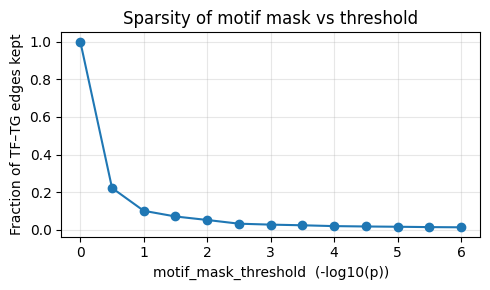

In [33]:
G, T = mask.shape
total_edges = G * T

thresholds = np.arange(0.0, 6.1, 0.5)

kept_counts = []
kept_fracs = []

for thr in thresholds:
    kept = np.count_nonzero(mask >= thr)
    kept_counts.append(kept)
    kept_fracs.append(kept / total_edges)

# Plot fraction kept vs threshold
plt.figure(figsize=(5, 3))
plt.plot(thresholds, kept_fracs, marker="o")
plt.xlabel("motif_mask_threshold  (-log10(p))")
plt.ylabel("Fraction of TF–TG edges kept")
plt.title("Sparsity of motif mask vs threshold")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Motif Prior Bias

We can use the sliding window scores to weight the TF-TG attention output.

$$\text{prior}_{g,t} = \text{motif\_prior\_scale} \times \text{clip} ( \text{mask}_{g,t}, 0, \text{max\_prior} )$$

This motif prior value is *added* as a bias term to the dot product similarity score between the TF and TG embeddings.

$$\text{sim}_{g,t} = \text{dot}(TG_{g},TF_{t}) + \lambda \times \hat{M}_{g,t}$$

Where $\hat{M}$ is the thresholded -log10(p) value between TF $t$ and TG $g$.

In the softmax over TFs for a given gene:

$$\text{Pr}(t | g) \propto \text{exp}(\text{sim}_{g,t})$$

The motif prior bias changes the odds ratio be $e^{prior}$. If two TFs, TF1 and TF2, have similar learned similarities, but TF1 has a strong motif prior giving +0.5 and TF2 has a motif prior of 0, then TF1 is $e^{0.5} \approx 1.65x$ more likely under the shortcut.

A **small** value for `motif_prior_scale` nudges the model, a **big** value heavily tilts the attention toward the motif-backed edges.

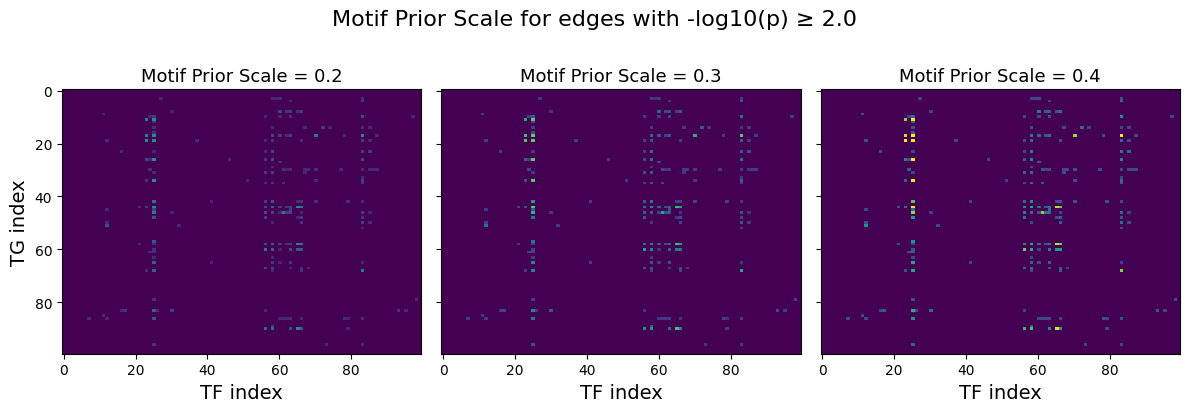

In [14]:
# mask: [G, T] with -log10(p) values
G, T = mask.shape

threshold = 2.0          # hard gating in -log10(p)
max_prior = 10.0         # optional clip for extreme values
scales = [0.2, 0.3, 0.4]
mask_sub = mask[:100, :100]
allowed = mask_sub >= threshold
clipped = np.clip(mask_sub, 0, max_prior) * allowed  # only allowed edges keep their score

fig, axes = plt.subplots(1, len(scales), figsize=(4*len(scales), 4), sharey=True)

for ax, s in zip(axes, scales):
    # this is the actual prior term added to sim for each TF–TG pair
    prior = s * clipped

    im = ax.imshow(prior, aspect="auto", interpolation="nearest",
                   vmin=0.0, vmax=max_prior * max(scales))
    ax.set_title(f"Motif Prior Scale = {s}", fontsize=13)
    ax.set_xlabel("TF index", fontsize=14)
    if ax is axes[0]:
        ax.set_ylabel("TG index", fontsize=14)

# fig.colorbar(im, ax=axes.ravel().tolist(),
#              label="Added similarity bias (motif_prior_scale × -log10(p))")
plt.suptitle(f"Motif Prior Scale for edges with -log10(p) ≥ {threshold}", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


We can also use the motif prior scaling without masking to boost the effect of TF-TG interactions with support from motif binding without restricting the number of TFs per TG.

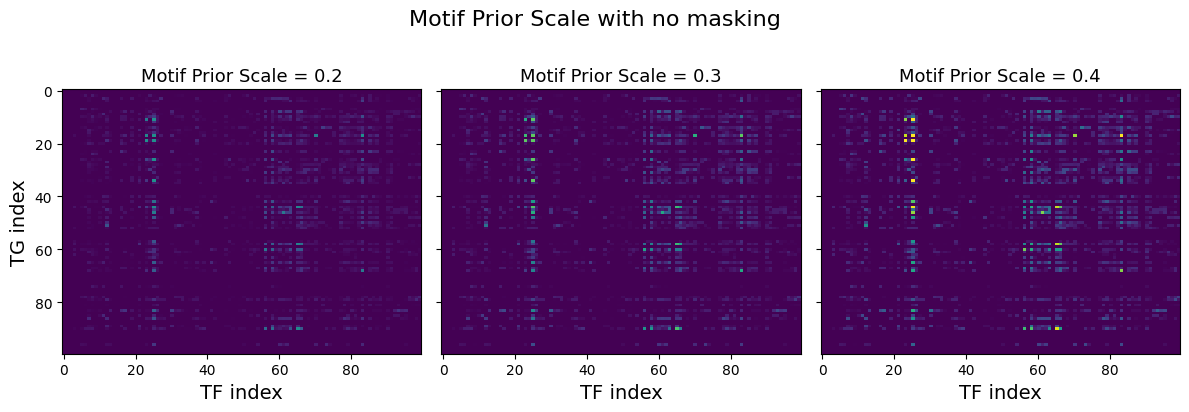

In [15]:
# mask: [G, T] with -log10(p) values
G, T = mask.shape

threshold = 0.0          # hard gating in -log10(p)
max_prior = 10.0         # optional clip for extreme values
scales = [0.2, 0.3, 0.4]
mask_sub = mask[:100, :100]
allowed = mask_sub >= threshold
clipped = np.clip(mask_sub, 0, max_prior) * allowed  # only allowed edges keep their score

fig, axes = plt.subplots(1, len(scales), figsize=(4*len(scales), 4), sharey=True)

for ax, s in zip(axes, scales):
    # this is the actual prior term added to sim for each TF–TG pair
    prior = s * clipped

    im = ax.imshow(prior, aspect="auto", interpolation="nearest",
                   vmin=0.0, vmax=max_prior * max(scales))
    ax.set_title(f"Motif Prior Scale = {s}", fontsize=13)
    ax.set_xlabel("TF index", fontsize=14)
    if ax is axes[0]:
        ax.set_ylabel("TG index", fontsize=14)

# fig.colorbar(im, ax=axes.ravel().tolist(),
#              label="Added similarity bias (motif_prior_scale × -log10(p))")
plt.suptitle(f"Motif Prior Scale with no masking", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

Nonzero edges: 7763


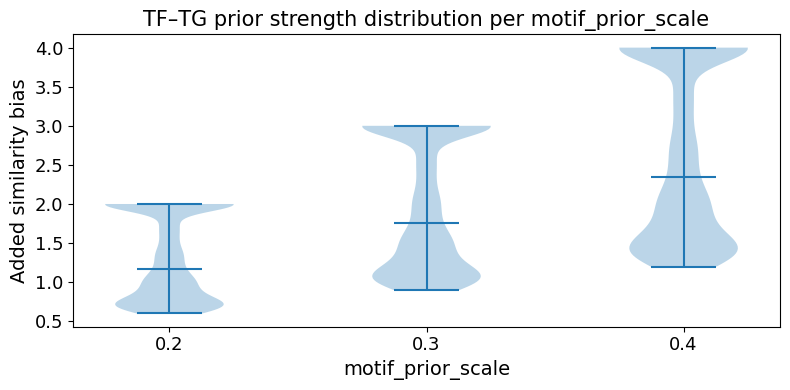

In [85]:
# Config: adjust these to match your model settings
thr = 3.0        # -log10(p) threshold for allowing edges
max_prior = 10.0 # clip raw motif score for prior term
scales = [0.0, 0.02, 0.05, 0.1, 0.2]

allowed = mask >= thr
clipped = np.clip(mask, 0, max_prior) * allowed

# Only consider edges that pass the hard mask (these get a prior)
base_vals = clipped[clipped > 0]
print("Nonzero edges:", base_vals.size)

quantiles = [0.25, 0.5, 0.9, 0.99]
lines = {q: [] for q in quantiles}

for s in scales:
    eff = s * base_vals
    for q in quantiles:
        lines[q].append(np.quantile(eff, q) if eff.size > 0 else 0.0)

scales = [0.2, 0.3, 0.4]

data = []
labels = []

for s in scales:
    eff = s * base_vals
    data.append(eff)
    labels.append(f"{s}")

plt.figure(figsize=(8, 4))
plt.violinplot(data, showmeans=False, showextrema=True, showmedians=True)
plt.xticks(np.arange(1, len(scales)+1), labels, fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("motif_prior_scale", fontsize=14)
plt.ylabel("Added similarity bias", fontsize=14)
plt.title("TF–TG prior strength distribution per motif_prior_scale", fontsize=15)
plt.tight_layout()
plt.show()


## Sliding Window PWM Binding Threshold

For each **motif**, we choose a **motif-specific score threshold** so that a single window exceeds this threshold with a fixed small false positive rate $\alpha$ when sequences are random. 200,000 random background window sequences are generated based on the background nucleotide frequencies. Finally, the binding potential between the PWM and the random sequences are calculated to generate a background distribution of PWM binding strengths.

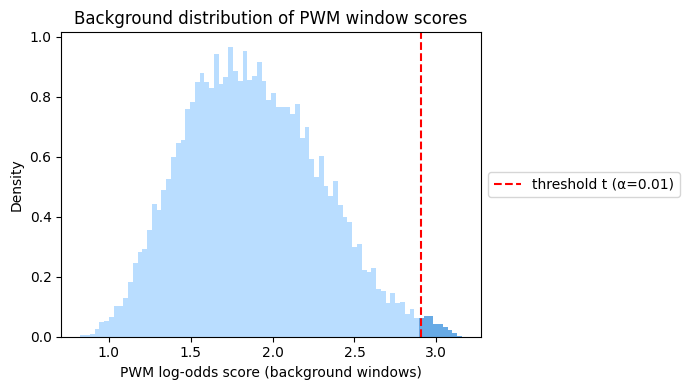

Estimated threshold t ≈ 2.909, so P_bg(score ≥ t) ≈ 0.01


In [117]:
def plot_pwm_bg_distribution(pwm_values, bg_freq, alpha=1e-4, num_samples=200000, bins=80):
    """
    Visualize background distribution of PWM window scores and the motif threshold.

    pwm_values : [w, 4] log-odds matrix for one motif
    bg_freq    : background base frequencies, either:
                 - array-like [pA, pC, pG, pT], or
                 - dict/Series with keys 'A','C','G','T'
    alpha      : desired per-window FPR for threshold line
    num_samples: number of background windows to sample
    bins       : histogram bins
    """
    w = pwm_values.shape[0]

    # normalize background frequencies
    if isinstance(bg_freq, (list, tuple, np.ndarray)):
        p = np.array(bg_freq, dtype=np.float64)
    else:  # dict / Series
        p = np.array([bg_freq["A"], bg_freq["C"], bg_freq["G"], bg_freq["T"]], dtype=np.float64)
    p = p / p.sum()

    # sample background windows: indices 0..3 = A,C,G,T
    idx = np.random.choice(4, size=(num_samples, w), p=p)  # [num_samples, w]

    # score each window: sum over positions of pwm[pos, base]
    pos = np.arange(w)[None, :]                    # [1, w] for broadcasting
    scores = pwm_values[pos, idx].sum(axis=1)      # [num_samples]

    # threshold t such that P(score >= t) ~= alpha
    t = np.quantile(scores, 1.0 - alpha)

    # plot
    plt.figure(figsize=(7, 4))

    # Create histogram and get bin data
    counts, bin_edges, patches = plt.hist(scores, bins=bins, density=True, alpha=0.8)

    # Color bars based on threshold
    for i, patch in enumerate(patches):
        bin_center = (bin_edges[i] + bin_edges[i+1]) / 2
        if bin_center >= t:
            patch.set_facecolor('#4195df')  # Darker blue for values >= threshold
        else:
            patch.set_facecolor('#a8d5ff')  # Lighter blue for values < threshold

    plt.axvline(t, color='red', linestyle='--', label=f"threshold t (α={alpha})")
    plt.xlabel("PWM log-odds score (background windows)")
    plt.ylabel("Density")
    plt.title("Background distribution of PWM window scores")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
    plt.tight_layout()
    plt.show()

    print(f"Estimated threshold t ≈ {t:.3f}, so P_bg(score ≥ t) ≈ {alpha}")
    return t, scores

motif_pwm = pd.read_csv("data/databases/motif_information/mm10/pwms_all_motifs/M00063_3.00.txt", sep="\t", header=0, index_col=0)
motif_pwm_np = motif_pwm.to_numpy()

mm10_background_freq = pd.Series({
    "A": 0.2917,
    "C": 0.2083,
    "G": 0.2083,
    "T": 0.2917
})

threshold, scores = plot_pwm_bg_distribution(motif_pwm_np, mm10_background_freq, alpha=0.01, num_samples=20_000)